In [1]:
import sys
sys.path.append("../../underactuated")

In [2]:
import numpy as np
from IPython.display import HTML, SVG, Math, display
from pydrake.all import (LinearQuadraticRegulator, DiagramBuilder, SceneGraph, WrapToSystem, LeafSystem,
                         MeshcatVisualizerCpp, Simulator, StartMeshcat, Saturation, Linearize, BasicVector)
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer

In [4]:
class Controller(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)
        quadrotor = Quadrotor2D()
        context = quadrotor.CreateDefaultContext()
        self.u0 = quadrotor.mass * quadrotor.gravity / 2. * np.array([1, 1])
        quadrotor.get_input_port(0).FixValue(context, self.u0)
        r = quadrotor.length
        self.x0 = np.zeros(6)
        context.get_mutable_continuous_state_vector()\
                    .SetFromVector(self.x0)
        linearized_quadrotor = Linearize(quadrotor, context)
        self.A = linearized_quadrotor.A()
        self.B = linearized_quadrotor.B()
        Q = np.diag([10, 10, 10, 1, 1, r/(2*np.pi)])
        R = np.array([[0.1, 0.05], [0.05, 0.1]])
        self.K = LinearQuadraticRegulator(self.A, self.B, Q, R)[0]
        self.state_input_port = self.DeclareVectorInputPort(
            "state", BasicVector(6))
        self.policy_output_port = self.DeclareVectorOutputPort(
            "policy", BasicVector(2), self.CalculateController)
        
    def CalculateController(self, context, output):
        x = self.state_input_port.Eval(context)
        y = output.get_mutable_value()
        y[:]  = -self.K@(x-self.x0) + self.u0  # Add u_equilibrium

In [5]:
def quadrotor_balancing_example():
    builder = DiagramBuilder()
    quadrotor = builder.AddSystem(Quadrotor2D())

    # saturation = builder.AddSystem(Saturation(min_value=[-10], max_value=[10]))
    # builder.Connect(saturation.get_output_port(0), quadrotor.get_input_port(0))
    wrapangles = WrapToSystem(6)
    wrapangles.set_interval(2, -np.pi, np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(quadrotor.get_output_port(0), wrapto.get_input_port(0))
    # controller = builder.AddSystem(BalancingLQR())
    controller = builder.AddSystem(Controller())
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), quadrotor.get_input_port(0))

    # Setup visualization
    visualizer = builder.AddSystem(Quadrotor2DVisualizer())
    builder.Connect(quadrotor.get_output_port(0), visualizer.get_input_port(0))
    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    visualizer.start_recording()
    print("simulating...")
#     for i in range(5):
    context.SetTime(0.)
    initial_state = np.random.randn(6,)
    context.SetContinuousState(initial_state)
    simulator.Initialize()
    simulator.AdvanceTo(5)
    print("done.\ngenerating animation...")
    ani = visualizer.get_recording_as_animation()
    display(HTML(ani.to_jshtml()))
    print("Initial state: ", initial_state)
    print("Final state: ", context.get_continuous_state_vector().CopyToVector())

simulating...


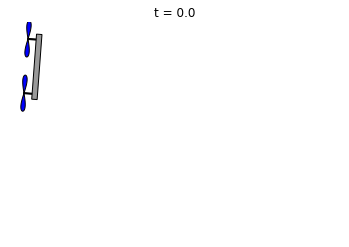

done.
generating animation...


Initial state:  [-1.26710119  0.59074975  1.4965404   0.43865298 -2.27051722 -0.92561263]
Final state:  [ 4.26592588e-10 -4.39025222e-14 -2.83531235e-07 -3.44462231e-08
 -6.92901900e-14  2.28943974e-05]


In [6]:
if __name__ == '__main__':
    quadrotor_balancing_example()
    # x_max = np.array([2*np.pi, np.pi/2, 3, 3])
    # x_min = np.array([0, -np.pi/2, -3, -3])
    # plot_lqr_cost_to_go(x_min, x_max)